## PRIDICT2 visualizations

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir
import Levenshtein
from tqdm import tqdm
import multiprocessing as mp
from brokenaxes import brokenaxes

In [2]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
def create_correlation_plot(rep_a_eff, rep_b_eff, rep_a_label, rep_b_label, plotting='plotting_yes', title=None, figsiztuple=(5,5)):
    
    R = stats.spearmanr(rep_a_eff, rep_b_eff)[0]
    r = stats.pearsonr(rep_a_eff, rep_b_eff)[0]
    if plotting == 'plotting_yes':
        xy = np.vstack([rep_a_eff, rep_b_eff])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        Correlation_x, Correlation_y, Correlation_z = rep_a_eff[idx], rep_b_eff[idx], z[idx]
        fig, ax = plt.subplots(figsize=figsiztuple, dpi=150)
        print(len(Correlation_x))
        ax.scatter(Correlation_x, Correlation_y, c=Correlation_z, s=0.03)
        ax.tick_params(axis='x', labelsize=10, width=1.5)
        ax.tick_params(axis='y', labelsize=10, width=1.5)
        ax.set_xlabel(rep_a_label, fontsize=lsize)
        ax.set_ylabel(rep_b_label, fontsize=lsize)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_xticks([0, 20, 40, 60, 80, 100])

        m, b = np.polyfit(rep_a_eff,rep_b_eff, 1)
        ax.plot(rep_a_eff, m*rep_a_eff + b, color='black', linewidth=1.2)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.text(0.05, 0.95, f'R = {R:.2f}\nr = {r:.2f}', transform=ax.transAxes, fontsize=lsize, verticalalignment='top')
        if title:
            ax.set_title(title, fontsize=16)

        figurepath = 'path/to/your/desired/directory/'
        #plt.savefig(figurepath + f'{rep_a_label}_and_{rep_b_label}_correlation.pdf', format='pdf', transparent=True, bbox_inches='tight')
        plt.show()

    return R, r


# Define function to list files
def list_files(directory):
    return [f for f in listdir(directory) if 'False_5runs.csv' in f]


### Create ML model comparison chart

In [4]:
# HEKpath = "C:\\Users\\nicol\\switchdrive\\PE_schwank\\epridict\\datasets_for_ml\\pridict2\\predictions_baseline\\baseline_evaluation_results_2023-08-31_16-37-46\\randomsearchCV\\baseline_models_HEKaverageedited_res\\"
HEKpath = "../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/predictions_baseline/baseline_evaluation_results_2023-08-31_16-37-46/randomsearchCV/baseline_models_HEKaverageedited_res/"



HEK_modelbenchmarkdf = pd.read_csv(HEKpath+'baseline_avgruns.csv')
HEK_modelbenchmarkdf = HEK_modelbenchmarkdf[HEK_modelbenchmarkdf['model_name'].str.contains("norm_False")]
HEK_modelbenchmarkdf['model_type'] = HEK_modelbenchmarkdf['model_name'].apply(lambda x: x[:-12])
HEK_modelnames = list(HEK_modelbenchmarkdf['model_type'])
HEK_modelbenchmarkdf

HEK_23k_spearmansummary = list(HEK_modelbenchmarkdf['avg_spearman_score'])
HEK_23k_spearmansummary.reverse()
HEK_23k_spearmanstdv = list(HEK_modelbenchmarkdf['spearman_score_std'])
HEK_23k_spearmanstdv.reverse()

HEK_23k_pearsonsummary = list(HEK_modelbenchmarkdf['avg_pear_score'])
HEK_23k_pearsonsummary.reverse()
HEK_23k_pearsonstdv = list(HEK_modelbenchmarkdf['pear_score_std'])
HEK_23k_pearsonstdv.reverse()

HEK_modelnames[4] = 'Histogram-based\nGradient Boosting'  # add line break for HistGradBoost
HEK_modelnames[5] = 'XGBoost'
HEK_modelnames.reverse()

# path = "C:\\Users\\nicol\\switchdrive\\PE_schwank\\epridict\\datasets_for_ml\\pridict2\\predictions_results\\pridict_inference_23klibrary_v2\\"
path = "../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/predictions_results/pridict_inference_23klibrary_v2/"


resdf = pd.read_csv(path+'res_df.csv')
HEK_23k_deepbenchmarkdf = resdf[(resdf['outcome_name'] == 'averageedited') & (resdf['model_id'] == 'base_23k_exp_2023-08-13_15-38-11') & (resdf['cell_type'] == 'HEK') & (resdf['correction_type'] == 'All')]
HEK_23k_averagedeepscore = HEK_23k_deepbenchmarkdf['spearman_score'].mean()
HEK_23k_deepstdv = HEK_23k_deepbenchmarkdf['spearman_score'].std()
HEK_23k_averagepearsondeepscore = HEK_23k_deepbenchmarkdf['pear_score'].mean()
HEK_23k_deeppearsonstdv = HEK_23k_deepbenchmarkdf['pear_score'].std()
HEK_23k_spearmansummary.insert(0,HEK_23k_averagedeepscore)
HEK_23k_spearmanstdv.insert(0,HEK_23k_deepstdv)
HEK_23k_pearsonsummary.insert(0,HEK_23k_averagepearsondeepscore)
HEK_23k_pearsonstdv.insert(0,HEK_23k_deeppearsonstdv)
HEK_modelnames.insert(0,'AttnBiRNN')

HEK_basicmodelsdf = pd.DataFrame()
HEK_basicmodelsdf['labels'] = HEK_modelnames
HEK_basicmodelsdf['spearmanscore'] = HEK_23k_spearmansummary
HEK_basicmodelsdf['spearmanstdv'] = HEK_23k_spearmanstdv
HEK_basicmodelsdf['pearsonscore'] = HEK_23k_pearsonsummary
HEK_basicmodelsdf['pearsonstdv'] = HEK_23k_pearsonstdv
HEK_basicmodelsdf = HEK_basicmodelsdf.sort_values(by='spearmanscore', ascending=False)
HEK_basicmodelsdf = HEK_basicmodelsdf.set_index('labels', drop=False)

In [5]:
# K562path = "C:\\Users\\nicol\\switchdrive\\PE_schwank\\epridict\\datasets_for_ml\\pridict2\\predictions_baseline\\baseline_evaluation_results_2023-09-01_12-08-18\\randomsearchCV\\baseline_models_K562averageedited_res\\"
K562path = "../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/predictions_baseline/baseline_evaluation_results_2023-09-01_12-08-18/randomsearchCV/baseline_models_K562averageedited_res/"

# Reading the K562 benchmark data
K562_modelbenchmarkdf = pd.read_csv(K562path+'baseline_avgruns.csv')
K562_modelbenchmarkdf = K562_modelbenchmarkdf[K562_modelbenchmarkdf['model_name'].str.contains("norm_False")]
K562_modelbenchmarkdf['model_type'] = K562_modelbenchmarkdf['model_name'].apply(lambda x: x[:-12])
K562_modellist = list_files(K562path)

# Filtering the deep model for K562
K562_deepbenchmarkdf = resdf[(resdf['outcome_name'] == 'averageedited') & (resdf['model_id'] == 'base_23k_exp_2023-08-13_15-38-11') & (resdf['cell_type'] == 'K562') & (resdf['correction_type'] == 'All')]
K562_averagedeepscore = K562_deepbenchmarkdf['spearman_score'].mean()
K562_deepstdv = K562_deepbenchmarkdf['spearman_score'].std()
K562_averagepearsondeepscore = K562_deepbenchmarkdf['pear_score'].mean()
K562_deeppearsonstdv = K562_deepbenchmarkdf['pear_score'].std()

# Insert deep model scores to the K562 benchmark list
K562_modelnames = list(K562_modelbenchmarkdf['model_type'])

K562_spearmansummary = list(K562_modelbenchmarkdf['avg_spearman_score'])
K562_spearmansummary.insert(0, K562_averagedeepscore)
K562_spearmanstdv = list(K562_modelbenchmarkdf['spearman_score_std'])
K562_spearmanstdv.insert(0, K562_deepstdv)
K562_pearsonsummary = list(K562_modelbenchmarkdf['avg_pear_score'])
K562_pearsonsummary.insert(0, K562_averagepearsondeepscore)
K562_pearsonstdv = list(K562_modelbenchmarkdf['pear_score_std'])
K562_pearsonstdv.insert(0, K562_deeppearsonstdv)

K562_modelnames[4] = 'Histogram-based\nGradient Boosting'  # add line break for HistGradBoost
K562_modelnames[5] = 'XGBoost'
K562_modelnames.insert(0, 'AttnBiRNN')


# Create the DataFrame for K562
K562_basicmodelsdf = pd.DataFrame()
K562_basicmodelsdf['labels'] = K562_modelnames
K562_basicmodelsdf['spearmanscore'] = K562_spearmansummary
K562_basicmodelsdf['spearmanstdv'] = K562_spearmanstdv
K562_basicmodelsdf['pearsonscore'] = K562_pearsonsummary
K562_basicmodelsdf['pearsonstdv'] = K562_pearsonstdv
K562_basicmodelsdf = K562_basicmodelsdf.sort_values(by='spearmanscore', ascending=False)
K562_basicmodelsdf = K562_basicmodelsdf.set_index('labels', drop=False)


In [6]:

# Initialize DataFrame and lists
editingindividualdf = pd.DataFrame()
editing_spearman_individual_run_value_summary = []
editing_pearson_individual_run_value_summary = []
namelist = []
cell_typelist = []

# Loop through each cell type and its corresponding variables
for cell_type, path, modelbenchmarkdf, deepbenchmarkdf in [('HEK', HEKpath, HEK_modelbenchmarkdf, HEK_23k_deepbenchmarkdf),
                                                            ('K562', K562path, K562_modelbenchmarkdf, K562_deepbenchmarkdf)]:
    modellist = list_files(path)
    modelbenchmarkdf = modelbenchmarkdf.sort_values(by=['avg_spearman_score'],ascending=False)
    
    for model in modellist:
        modelshortname = model.split('_')[0]
        ind = modelbenchmarkdf.index[modelbenchmarkdf['model_type'] == modelshortname].tolist()[0]
        fiverundf = pd.read_csv(path + model)
        
        for runnr in range(0,5):
            spearman_value = fiverundf.at[0,'run_'+str(runnr)]
            pearson_value = fiverundf.at[1,'run_'+str(runnr)]
            modelbenchmarkdf.at[ind,'editing_individual_spearman_run_'+str(runnr)] = spearman_value
            modelbenchmarkdf.at[ind,'editing_individual_pearson_run_'+str(runnr)] = pearson_value
    
    for index, row in modelbenchmarkdf.iterrows():
        for runnr in range(0,5):
            editing_spearman_individual_run_value_summary.append(row['editing_individual_spearman_run_'+str(runnr)])
            editing_pearson_individual_run_value_summary.append(row['editing_individual_pearson_run_'+str(runnr)])
            namelist.append(row['model_type'])
            cell_typelist.append(cell_type)
    
    individual_spearman_values = list(deepbenchmarkdf['spearman_score'])
    individual_pearson_values = list(deepbenchmarkdf['pear_score'])
    
    for runnr in range(0,5):
        editing_spearman_individual_run_value_summary.insert(0, individual_spearman_values[runnr])
        editing_pearson_individual_run_value_summary.insert(0, individual_pearson_values[runnr])
        namelist.insert(0, 'AttnBiRNN')  # Your deep model name
        cell_typelist.insert(0, cell_type)

# Populate DataFrame
editingindividualdf['names'] = namelist
editingindividualdf['editing_spearmanvalues'] = editing_spearman_individual_run_value_summary
editingindividualdf['editing_pearsonvalues'] = editing_pearson_individual_run_value_summary
editingindividualdf['cell_type'] = cell_typelist

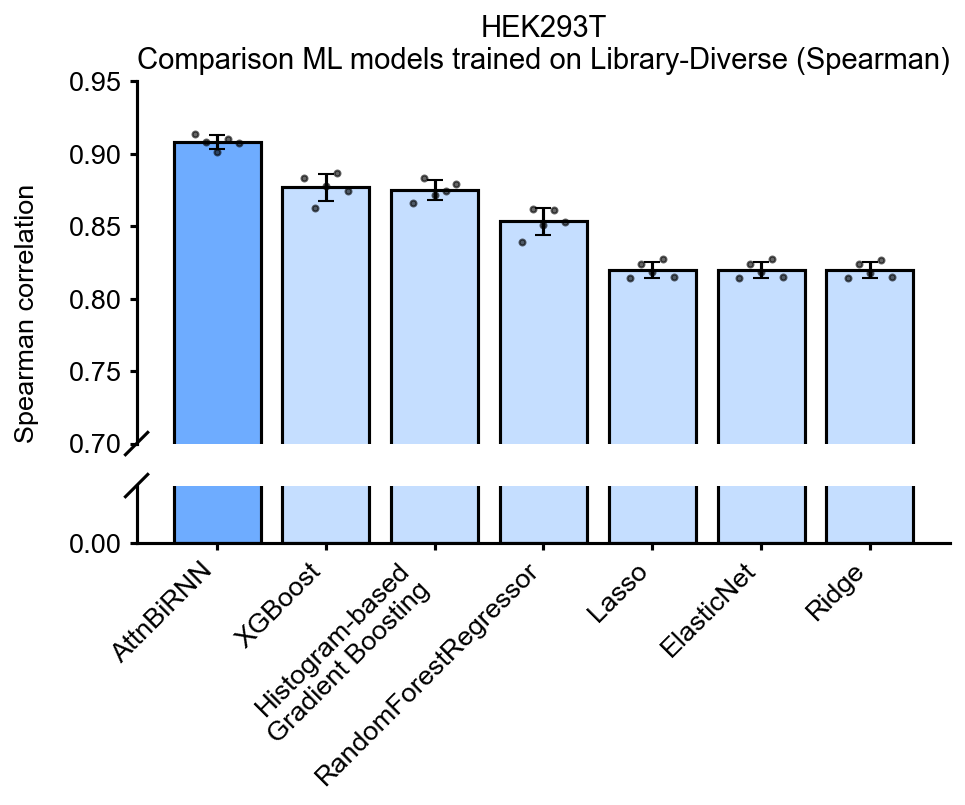

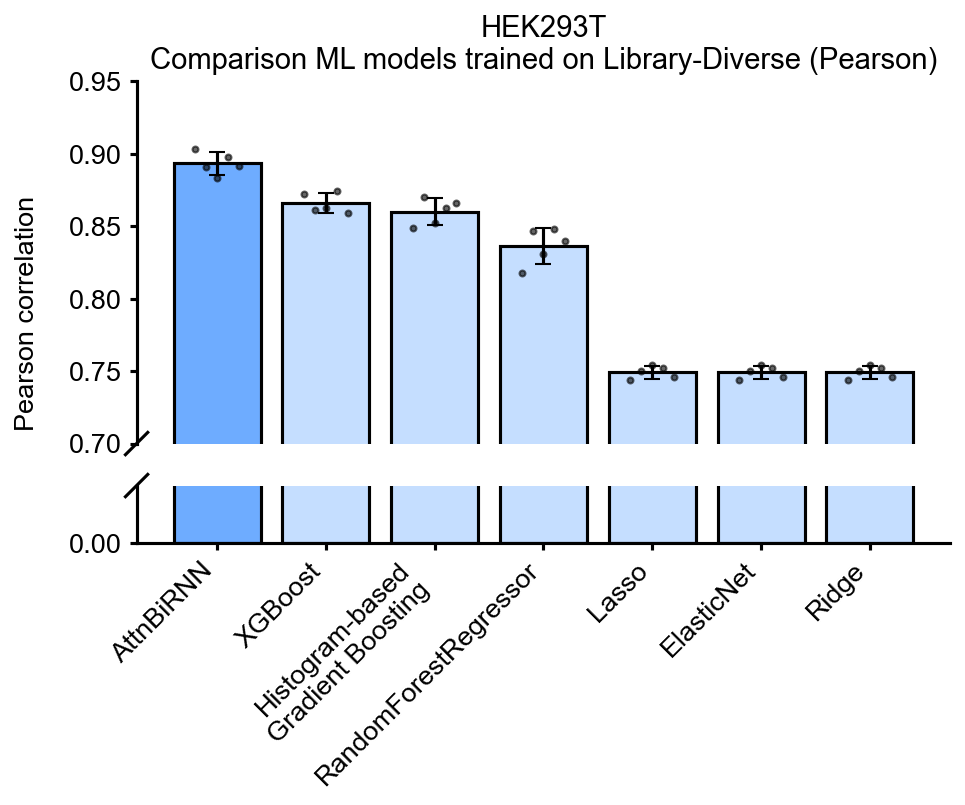

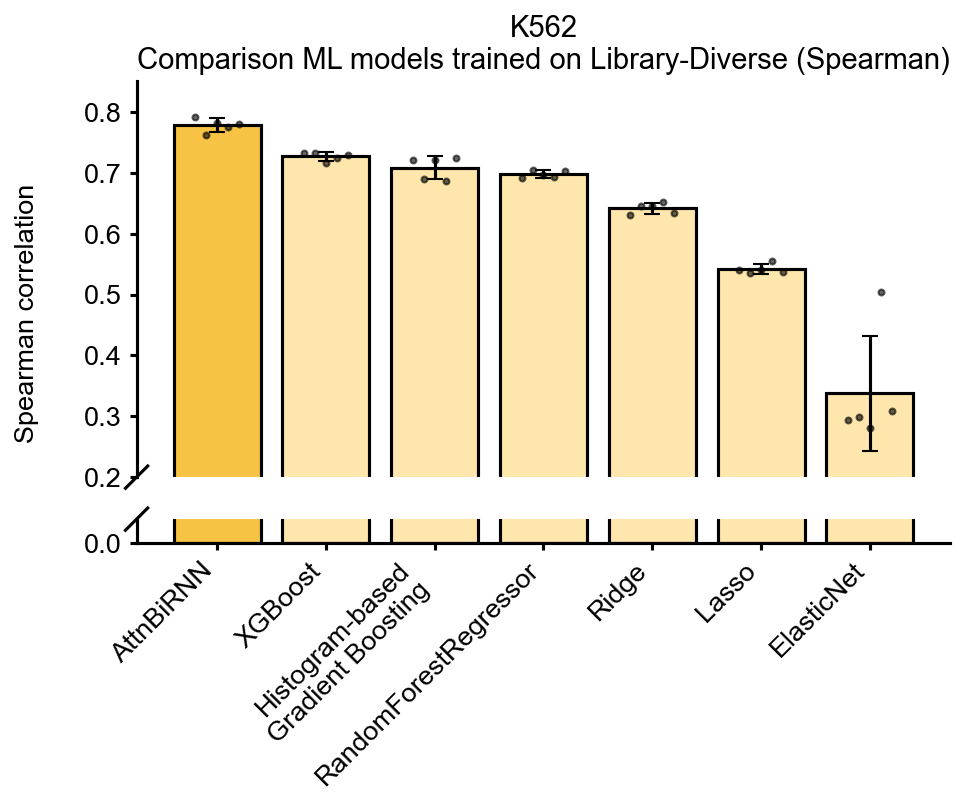

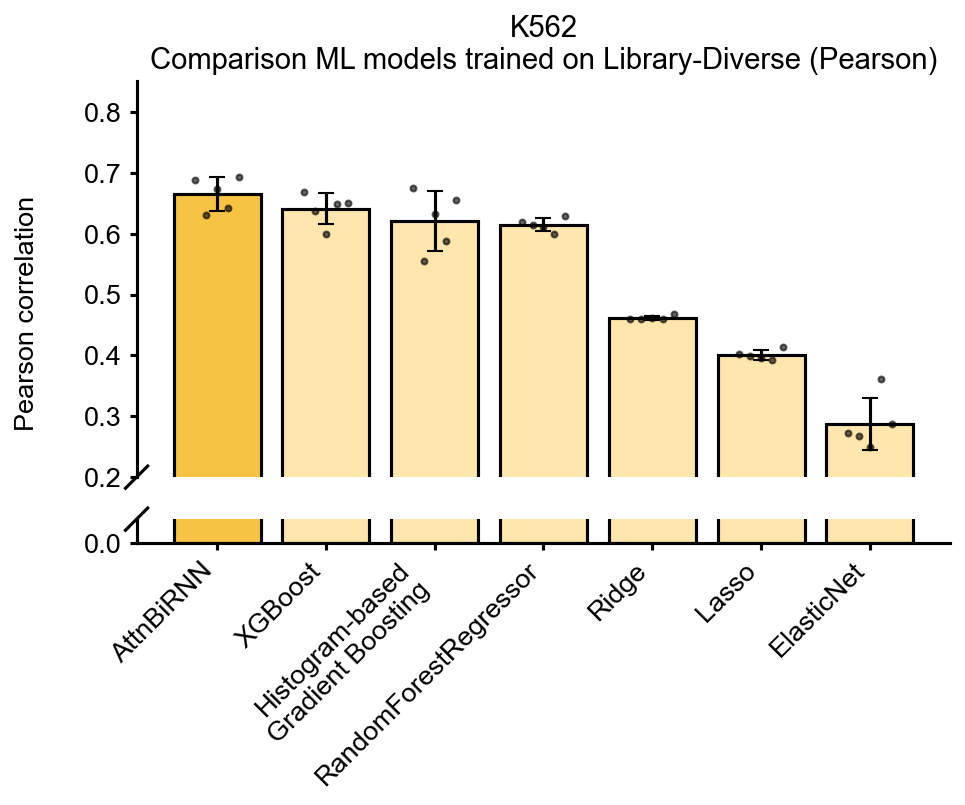

In [7]:
def plot_comparison(cell_type, basicmodelsdf, ylims, corr_type, score_column, std_column, editingindividualdf, bar_kwargs, bar_color, first_bar_color):
    # Filter to get only the specific cell type data
    cell_filter = editingindividualdf['cell_type'] == cell_type.split("293T")[0]  # remove '293T' if present
    cell_editing_individual_run_value_summary = editingindividualdf[cell_filter][f'editing_{corr_type.lower()}values'].tolist()
    
    fig = plt.figure(figsize=(7, 4), dpi=150)
    bax = brokenaxes(ylims=ylims, hspace=.2)
    
    bax.set_title(f'{cell_type}\nComparison ML models trained on Library-Diverse ({corr_type})', fontsize=14)
    new_bar_kwargs = {**bar_kwargs, 'color': bar_color}
    bar_containers = bax.bar(basicmodelsdf['labels'], basicmodelsdf[score_column], yerr=basicmodelsdf[std_column], **new_bar_kwargs)    
    # Scatter plot for individual run values
    x = list(basicmodelsdf['labels'])
    y = cell_editing_individual_run_value_summary
    counter = 0
    for i in range(len(x)):
        for runnr in range(5):
            bax.scatter(i+(runnr/5-0.4)/2, y[counter], s=8, color='black', edgecolors='face', alpha=0.6, zorder=2)
            counter += 1
            
    # Styling
    bax.axs[-1].set_xticks(range(len(basicmodelsdf['labels'])))
    bax.axs[-1].set_xticklabels(basicmodelsdf['labels'], ha="right")
    bax.set_ylabel(f'{corr_type} correlation\n', fontsize=13)
    bax.tick_params(axis='x', labelsize=13, width=1.5, rotation=45)
    bax.tick_params(axis='y', labelsize=13, width=1.5)
    
    # Recolor the first bar
    for container in bar_containers:
        container.patches[0].set_facecolor(first_bar_color)
    
    
    # Save the figure
    figurepath = f'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\02_ML_models\\'
    # Uncomment to save
    # plt.savefig(f'{figurepath}ml_model_comparison_{cell_type}_{corr_type.lower()}_brokenaxis.pdf', format='pdf', transparent=True, bbox_inches='tight')

# Define the ylims for each cell type
ylim_HEK = ((0, .04), (.7, .95))
ylim_K562 = ((0, .04), (.2, .85))  # Replace with the appropriate values for K562

# Define colors for each cell type
HEK_bar_color = '#C5DEFF'  # Default gray
HEK_first_bar_color = '#6eacff'  # Specific color for the first bar
K562_bar_color = '#FEE6AC'  # Your specified color for K562 bars
K562_first_bar_color = '#f7c345'  # Your specified color for the first K562 bar

# Loop through each cell type and correlation type
for cell_type, basicmodelsdf, ylims, bar_color, first_bar_color in [("HEK293T", HEK_basicmodelsdf, ylim_HEK, HEK_bar_color, HEK_first_bar_color), 
                                                                    ("K562", K562_basicmodelsdf, ylim_K562, K562_bar_color, K562_first_bar_color)]:
    for corr_type, score_column, std_column in [("Spearman", "spearmanscore", "spearmanstdv"),
                                                ("Pearson", "pearsonscore", "pearsonstdv")]:
        plot_comparison(cell_type, basicmodelsdf, ylims, corr_type, score_column, std_column, editingindividualdf, bar_kwargs, bar_color, first_bar_color)


### Import predictions and map them to library members

In [9]:
# import original overviewdataframe
overviewdataframe = pd.read_csv('../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/dataset/schwank_proc_v2/23k_library/data_df_23kschwank_v1.csv')
overviewdataframe = overviewdataframe.set_index('seq_id')

# modeldict = {'23k_MFE_old': 'pridict_inference_base_23k/exp_2023-07-18_20-36-11/', '23k': 'pridict_inference_base_23k_v2/exp_2023-08-13_15-38-11/', '90k_FT': 'pridict_inference_base_90k_decinit_HEKschwank_FT/exp_2023-07-19_18-01-48/','390k_FT':'pridict_inference_base_390k_decinit_HEKschwank_FT/exp_2023-07-19_22-18-21/'}

modeldict = {'23k': 'pridict_inference_base_23k_v2/exp_2023-08-13_15-38-11/', '90k_FT': 'pridict_inference_base_90k_decinit_HEKschwank_FT_v2/exp_2023-08-25_20-55-53/','390k_FT':'pridict_inference_base_390k_decinit_HEKschwank_FT_v2/exp_2023-08-28_22-22-26/'}
for model in modeldict:
    # path_prefix = '../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/dataset/schwank_proc_v2/predictions/'
    path_prefix = '../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/predictions_results/pridict_inference_23klibrary_v2/'

    path = path_prefix + modeldict[model]
    # get all files within the folder path into a list
    filelist = [f for f in listdir(path) if '.csv' in f]
    hekpredictionlist = [f for f in filelist if 'HEK' in f]
    k562predictionlist = [f for f in filelist if 'K562' in f]

    # Combine all hek files in one hekpredictiondataframe
    hek_dataframes = [pd.read_csv(path+file) for file in hekpredictionlist]
    hekpredictiondataframe = pd.concat(hek_dataframes, ignore_index=True)
    hekpredictiondataframe['nr'] = hekpredictiondataframe['seq_id'].str.split('_').str[1]
    # sort by nr
    hekpredictiondataframe['nr'] = hekpredictiondataframe['nr'].astype(int)
    hekpredictiondataframe = hekpredictiondataframe.sort_values(by=['nr'])
    hekpredictiondataframe = hekpredictiondataframe.set_index('seq_id')

    # Combine all k562 files in one k562predictiondataframe
    k562_dataframes = [pd.read_csv(path+file) for file in k562predictionlist]
    k562predictiondataframe = pd.concat(k562_dataframes, ignore_index=True)
    k562predictiondataframe['nr'] = k562predictiondataframe['seq_id'].str.split('_').str[1]
    # sort by nr
    k562predictiondataframe['nr'] = k562predictiondataframe['nr'].astype(int)
    k562predictiondataframe = k562predictiondataframe.sort_values(by=['nr'])
    k562predictiondataframe = k562predictiondataframe.set_index('seq_id')

    
    overviewdataframe[model+'_HEK_true_averageedited'] = hekpredictiondataframe['true_averageedited'].apply(lambda x: x*100)
    overviewdataframe[model+'_K562_true_averageedited'] = k562predictiondataframe['true_averageedited'].apply(lambda x: x*100)
    overviewdataframe[model+'_HEK_pred_averageedited'] = hekpredictiondataframe['pred_averageedited'].apply(lambda x: x*100)
    overviewdataframe[model+'_K562_pred_averageedited'] = k562predictiondataframe['pred_averageedited'].apply(lambda x: x*100)


overviewdataframe['90k_390k_ensemble_HEK_pred_averageedited'] = (overviewdataframe['90k_FT_HEK_pred_averageedited'] + overviewdataframe['390k_FT_HEK_pred_averageedited'])/2
overviewdataframe['90k_390k_ensemble_K562_pred_averageedited'] = (overviewdataframe['90k_FT_K562_pred_averageedited'] + overviewdataframe['390k_FT_K562_pred_averageedited'])/2

# the true value is the same for all models, so in theory averaging them is not necessary
overviewdataframe['90k_390k_ensemble_HEK_true_averageedited'] = (overviewdataframe['90k_FT_HEK_true_averageedited'] + overviewdataframe['390k_FT_HEK_true_averageedited'])/2
overviewdataframe['90k_390k_ensemble_K562_true_averageedited'] = (overviewdataframe['90k_FT_K562_true_averageedited'] + overviewdataframe['390k_FT_K562_true_averageedited'])/2

df_with_pridict_predictions = pd.read_csv('dataframes/20230709_451_templatedf_with_editing_and_predictions_and_groups.csv')
# rename index to "seq_" + str( of the current index)
df_with_pridict_predictions['seq_id'] = df_with_pridict_predictions.index
df_with_pridict_predictions['seq_id'] = df_with_pridict_predictions['seq_id'].apply(lambda x: 'seq_'+str(x))

df_with_pridict_predictions = df_with_pridict_predictions.set_index('seq_id')

overviewdataframe['PRIDICT2.0 HEK293T'] = overviewdataframe['90k_390k_ensemble_HEK_pred_averageedited']
overviewdataframe['PRIDICT2.0 K562'] = overviewdataframe['90k_390k_ensemble_K562_pred_averageedited']
overviewdataframe['PRIDICT_score'] = df_with_pridict_predictions['PRIDICT_editing_Score_deep']

overviewdataframe.to_csv('dataframes/20230904_templatedf_with_differentmodel_predictions.csv')

C:\Users\nicol\AppData\Local\Temp\ipykernel_19400\2836550804.py:2: DtypeWarning: Columns (53,66) have mixed types. Specify dtype option on import or set low_memory=False.
  overviewdataframe = pd.read_csv('../../../../../../../PE_schwank/epridict/datasets_for_ml/pridict2/dataset/schwank_proc_v2/23k_library/data_df_23kschwank_v1.csv')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19400\2836550804.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  overviewdataframe[model+'_K562_pred_averageedited'] = k562predictiondataframe['pred_averageedited'].apply(lambda x: x*100)
C:\Users\nicol\AppData\Local\Temp\ipykernel_19400\2836550804.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [10]:
# Function to calculate Pearson and Spearman correlation
def calculate_correlations(true_values, predicted_values):
    spearman_corr, _ = stats.spearmanr(true_values, predicted_values)
    pearson_corr, _ = stats.pearsonr(true_values, predicted_values)
    return spearman_corr, pearson_corr

# Function to drop rows with NaN in either of two columns and return the filtered series
def drop_na_pairs(series1, series2):
    combined_df = pd.DataFrame({'s1': series1, 's2': series2})
    filtered_df = combined_df.dropna()
    return filtered_df['s1'], filtered_df['s2']

# Overall correlations for PRIDICT across the whole library
# For HEK293T
print('PRIDICT correlations:')
hek_overall_true, hek_overall_pred = drop_na_pairs(overviewdataframe['HEKaverageedited'], overviewdataframe['PRIDICT_score'])
overall_spearman_HEK, overall_pearson_HEK = calculate_correlations(hek_overall_true, hek_overall_pred)
print(f"Overall Spearman correlation for HEK293T (PRIDICT): {round(overall_spearman_HEK,2)}")
print(f"Overall Pearson correlation for HEK293T (PRIDICT): {round(overall_pearson_HEK,2)}")

# For K562
k562_overall_true, k562_overall_pred = drop_na_pairs(overviewdataframe['K562averageedited'], overviewdataframe['PRIDICT_score'])
overall_spearman_K562, overall_pearson_K562 = calculate_correlations(k562_overall_true, k562_overall_pred)
print(f"Overall Spearman correlation for K562 (PRIDICT): {round(overall_spearman_K562,2)}")
print(f"Overall Pearson correlation for K562 (PRIDICT): {round(overall_pearson_K562,2)}")

print('PRIDICT2 correlatiosn:')
hek_overall_true, hek_overall_pred = drop_na_pairs(overviewdataframe['HEKaverageedited'], overviewdataframe['PRIDICT2.0 HEK293T'])
overall_spearman_HEK, overall_pearson_HEK = calculate_correlations(hek_overall_true, hek_overall_pred)
print(f"Overall Spearman correlation for HEK293T (PRIDICT2.0 HEK293T): {round(overall_spearman_HEK,2)}")
print(f"Overall Pearson correlation for HEK293T (PRIDICT2.0 HEK293T): {round(overall_pearson_HEK,2)}")

# For K562
k562_overall_true, k562_overall_pred = drop_na_pairs(overviewdataframe['K562averageedited'], overviewdataframe['PRIDICT2.0 K562'])
overall_spearman_K562, overall_pearson_K562 = calculate_correlations(k562_overall_true, k562_overall_pred)
print(f"Overall Spearman correlation for K562 (PRIDICT2.0 K562): {round(overall_spearman_K562,2)}")
print(f"Overall Pearson correlation for K562 (PRIDICT2.0 K562): {round(overall_pearson_K562,2)}")

PRIDICT correlations:
Overall Spearman correlation for HEK293T (PRIDICT): 0.82
Overall Pearson correlation for HEK293T (PRIDICT): 0.78
Overall Spearman correlation for K562 (PRIDICT): 0.63
Overall Pearson correlation for K562 (PRIDICT): 0.4
PRIDICT2 correlatiosn:
Overall Spearman correlation for HEK293T (PRIDICT2.0 HEK293T): 0.91
Overall Pearson correlation for HEK293T (PRIDICT2.0 HEK293T): 0.89
Overall Spearman correlation for K562 (PRIDICT2.0 K562): 0.81
Overall Pearson correlation for K562 (PRIDICT2.0 K562): 0.7


22619


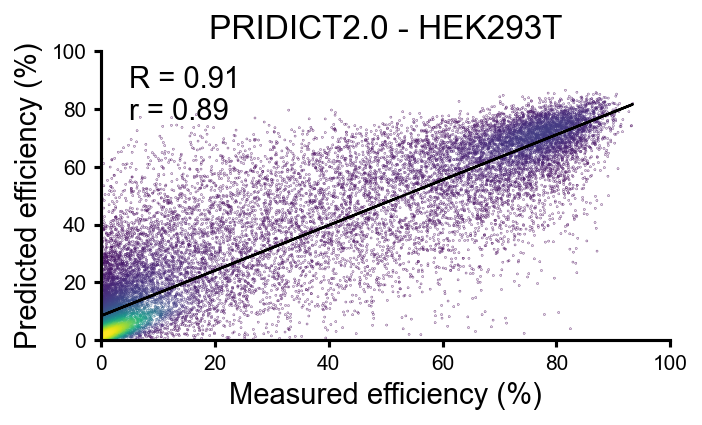

22752


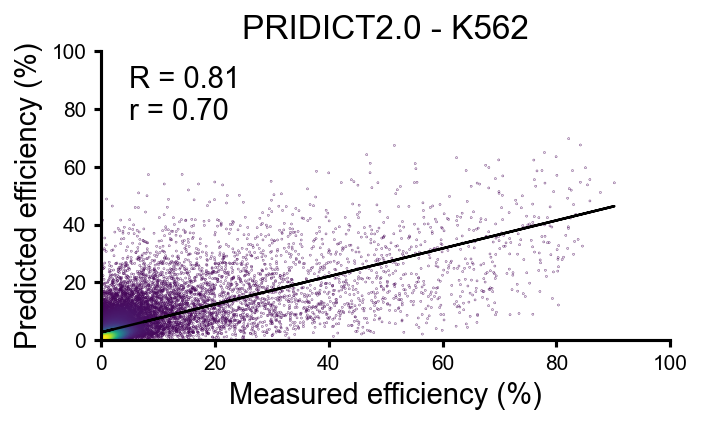

In [11]:
modeldict = {'90k_390k_ensemble':''}

spearmandict_all_hek = {}
pearsondict_all_hek = {}
spearmandict_all_k562 = {}
pearsondict_all_k562 = {}

for model in modeldict:    
    interested_columns_HEK = [model+'_HEK_true_averageedited',
                        model+'_HEK_pred_averageedited']

    hekdf = overviewdataframe.dropna(subset=interested_columns_HEK).copy()

    hek_true = hekdf[model+'_HEK_true_averageedited'].reset_index(drop=True)
    hek_pred = hekdf[model+'_HEK_pred_averageedited'].reset_index(drop=True)

    if model == '90k_390k_ensemble':
        R, r = create_correlation_plot(hek_true, hek_pred, 'Measured efficiency (%)', 'Predicted efficiency (%)', 'plotting_yes', f'PRIDICT2.0 - HEK293T', (4.9,2.5))
    else:
        R, r = create_correlation_plot(hek_true, hek_pred, 'Measured efficiency (%)', 'Predicted efficiency (%)', 'plotting_yes', f'HEK293T - {model} - Prediction correlations')

    spearmandict_all_hek[model] = R
    pearsondict_all_hek[model] = r
    interested_columns_K562 = [model+'_K562_true_averageedited',
                            model+'_K562_pred_averageedited']
    k562df = overviewdataframe.dropna(subset=interested_columns_K562).copy()

    k562_true = k562df[model+'_K562_true_averageedited'].reset_index(drop=True)
    k562_pred = k562df[model+'_K562_pred_averageedited'].reset_index(drop=True)

    if model == '90k_390k_ensemble':
        R, r = create_correlation_plot(k562_true, k562_pred, 'Measured efficiency (%)', 'Predicted efficiency (%)', 'plotting_yes', f'PRIDICT2.0 - K562', (4.9,2.5))
    else:
        R, r = create_correlation_plot(k562_true, k562_pred, 'Measured efficiency (%)', 'Predicted efficiency (%)', 'plotting_yes', f'K562 - {model} - Prediction correlations')
    spearmandict_all_k562[model] = R
    pearsondict_all_k562[model] = r

In [12]:
mutation_types = ['1bpReplacement', 'MultibpReplacement', 'Insertion', 'Deletion']

spearmandict_hek_mutation = {}
pearsondict_hek_mutation = {}
spearmandict_k562_mutation = {}
pearsondict_k562_mutation = {}

for model in modeldict:
    spearmandict_hek_mutation[model] = {}
    pearsondict_hek_mutation[model] = {}
    spearmandict_k562_mutation[model] = {}
    pearsondict_k562_mutation[model] = {}
    
    for mutation in mutation_types:
        subset_df = overviewdataframe[overviewdataframe['Mutation_Type'] == mutation]
        
        # For HEK
        interested_columns_HEK = [
            model+'_HEK_true_averageedited',
            model+'_HEK_pred_averageedited'
        ]

        hekdf = subset_df.dropna(subset=interested_columns_HEK).copy()
        hek_true = hekdf[model+'_HEK_true_averageedited'].reset_index(drop=True)
        hek_pred = hekdf[model+'_HEK_pred_averageedited'].reset_index(drop=True)
        
        R, r = create_correlation_plot(
            hek_true, 
            hek_pred, 
            'Editing efficiency (%)', 
            'Predicted editing efficiency (%)', 'plotting_no',
            f'HEK293T - {model} - {mutation} - Prediction correlations\n'
        )

        spearmandict_hek_mutation[model][mutation] = R
        pearsondict_hek_mutation[model][mutation] = r

        # For K562
        interested_columns_K562 = [
            model+'_K562_true_averageedited',
            model+'_K562_pred_averageedited'
        ]

        k562df = subset_df.dropna(subset=interested_columns_K562).copy()
        k562_true = k562df[model+'_K562_true_averageedited'].reset_index(drop=True)
        k562_pred = k562df[model+'_K562_pred_averageedited'].reset_index(drop=True)

        R, r = create_correlation_plot(
            k562_true, 
            k562_pred, 
            'Editing efficiency (%)', 
            'Predicted editing efficiency (%)', 'plotting_no',
            f'K562 - {model} - {mutation} - Prediction correlations\n'
        )

        spearmandict_k562_mutation[model][mutation] = R
        pearsondict_k562_mutation[model][mutation] = r


In [13]:
df_with_predictions = pd.read_csv('dataframes/20230709_451_templatedf_with_editing_and_predictions_and_groups.csv')


C:\Users\nicol\AppData\Local\Temp\ipykernel_19400\1076433580.py:1: DtypeWarning: Columns (53,66,285) have mixed types. Specify dtype option on import or set low_memory=False.
  df_with_predictions = pd.read_csv('dataframes/20230709_451_templatedf_with_editing_and_predictions_and_groups.csv')


In [14]:
mutation_types = ['1bpReplacement', 'MultibpReplacement', 'Insertion', 'Deletion']

for model in ['PRIDICT1']:
    spearmandict_hek_mutation[model] = {}
    pearsondict_hek_mutation[model] = {}
    spearmandict_k562_mutation[model] = {}
    pearsondict_k562_mutation[model] = {}
    
    for mutation in mutation_types:
        subset_df = df_with_predictions[df_with_predictions['Mutation_Type'] == mutation]
        
        # For HEK
        interested_columns_HEK = ['HEKaverageedited','PRIDICT_editing_Score_deep']

        hekdf = subset_df.dropna(subset=interested_columns_HEK).copy()
        hek_true = hekdf['HEKaverageedited'].reset_index(drop=True)
        hek_pred = hekdf['PRIDICT_editing_Score_deep'].reset_index(drop=True)
        
        R, r = create_correlation_plot(
            hek_true, 
            hek_pred, 
            'Editing efficiency (%)', 
            'Predicted editing efficiency (%)', 'plotting_no',
            f'HEK293T - {model} - {mutation} - Prediction correlations\n'
        )

        spearmandict_hek_mutation[model][mutation] = R
        pearsondict_hek_mutation[model][mutation] = r

        # For K562
        interested_columns_K562 = ['K562averageedited','PRIDICT_editing_Score_deep']

        k562df = subset_df.dropna(subset=interested_columns_K562).copy()
        k562_true = k562df['K562averageedited'].reset_index(drop=True)
        k562_pred = k562df['PRIDICT_editing_Score_deep'].reset_index(drop=True)

        R, r = create_correlation_plot(
            k562_true, 
            k562_pred, 
            'Editing efficiency (%)', 
            'Predicted editing efficiency (%)', 'plotting_no',
            f'K562 - {model} - {mutation} - Prediction correlations\n'
        )

        spearmandict_k562_mutation[model][mutation] = R
        pearsondict_k562_mutation[model][mutation] = r


meta NOT subset; don't know how to subset; dropped


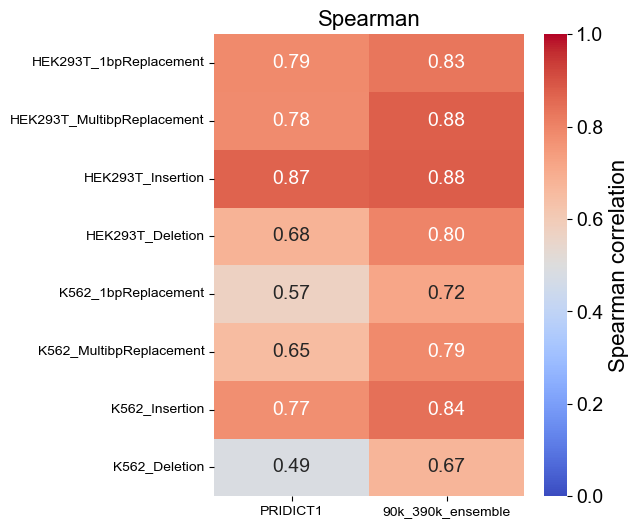

meta NOT subset; don't know how to subset; dropped


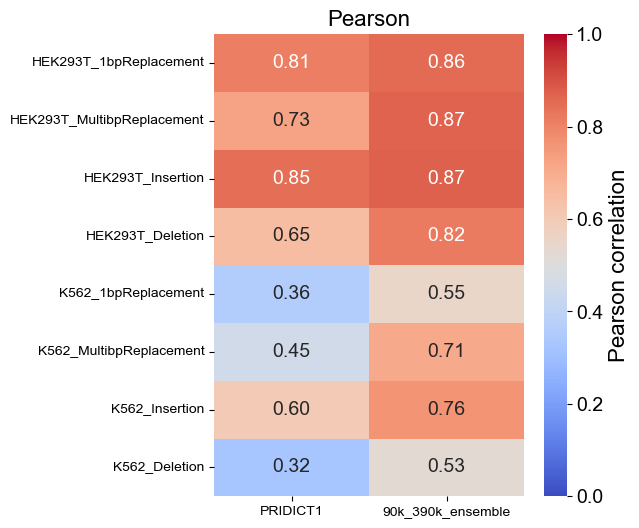

In [15]:
modeldict = {'PRIDICT1':'',
 '90k_390k_ensemble': ''}

# Initialize empty DataFrames
spearman_df_hek = pd.DataFrame()
spearman_df_k562 = pd.DataFrame()
pearson_df_hek = pd.DataFrame()
pearson_df_k562 = pd.DataFrame()

def plot_combined_heatmap(df, title, filename=None):
    plt.figure(figsize=(5, 6))
    ax = sn.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14},
                     vmin=0, vmax=1, cbar_kws={'label': 'Correlation Value'})
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel(title + ' correlation', size=16)
    cbar.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=16)
    
    if filename:
        path = '../08_Paper/01_Figures/Extended_2_PRIDICT2/'
        plt.savefig(f"{path}{filename}", format='pdf')
        
    plt.show()


for mutation_type in mutation_types:
    hek_spearman_mutation = {model: spearmandict_hek_mutation[model][mutation_type] for model in modeldict}
    k562_spearman_mutation = {model: spearmandict_k562_mutation[model][mutation_type] for model in modeldict}
    hek_pearson_mutation = {model: pearsondict_hek_mutation[model][mutation_type] for model in modeldict}
    k562_pearson_mutation = {model: pearsondict_k562_mutation[model][mutation_type] for model in modeldict}

    # Append to DataFrame using concat
    spearman_df_hek = pd.concat([spearman_df_hek, pd.DataFrame(hek_spearman_mutation, index=[f'HEK293T_{mutation_type}'])])
    spearman_df_k562 = pd.concat([spearman_df_k562, pd.DataFrame(k562_spearman_mutation, index=[f'K562_{mutation_type}'])])
    pearson_df_hek = pd.concat([pearson_df_hek, pd.DataFrame(hek_pearson_mutation, index=[f'HEK293T_{mutation_type}'])])
    pearson_df_k562 = pd.concat([pearson_df_k562, pd.DataFrame(k562_pearson_mutation, index=[f'K562_{mutation_type}'])])

# Concatenate HEK293T and K562 in the desired order
spearman_df = pd.concat([spearman_df_hek, spearman_df_k562])
pearson_df = pd.concat([pearson_df_hek, pearson_df_k562])

# Generate Combined Heatmaps
plot_combined_heatmap(spearman_df, 'Spearman', '20230905_heatmap_selected_models_spearman.pdf')
plot_combined_heatmap(pearson_df, 'Pearson', '20230905_heatmap_selected_models_pearson.pdf')


In [16]:
# Initialize dictionaries to store the results
spearmandict_length = {'90k_390k_ensemble': {'HEK': {}, 'K562': {}}, 'PRIDICT1': {'HEK': {}, 'K562': {}}}
pearsondict_length = {'90k_390k_ensemble': {'HEK': {}, 'K562': {}}, 'PRIDICT1': {'HEK': {}, 'K562': {}}}

models_to_compare = ['90k_390k_ensemble', 'PRIDICT1']
mutation_length_types = ['Insertion', 'Deletion']

# Loop through each model
for model in models_to_compare:

    # Loop through mutation lengths
    for mutation_length in mutation_length_types:
        spearmandict_length[model]['HEK'][mutation_length] = {}
        spearmandict_length[model]['K562'][mutation_length] = {}
        
        pearsondict_length[model]['HEK'][mutation_length] = {}
        pearsondict_length[model]['K562'][mutation_length] = {}
        
        for length in range(1, 16):  # Looping from 1 to 15
            
            # Extract relevant columns based on the model
            if model == "90k_390k_ensemble":
                subset_df = overviewdataframe[(overviewdataframe['Mutation_Type'] == mutation_length) & (overviewdataframe['Correction_Length'] == length)]
                hek_col = '90k_390k_ensemble_HEK_true_averageedited'
                k562_col = '90k_390k_ensemble_K562_true_averageedited'
                hek_pred_col = '90k_390k_ensemble_HEK_pred_averageedited'
                k562_pred_col = '90k_390k_ensemble_K562_pred_averageedited'
            elif model == "PRIDICT1":
                subset_df = df_with_predictions[(df_with_predictions['Mutation_Type'] == mutation_length) & (df_with_predictions['Correction_Length'] == length)]
                hek_col = 'HEKaverageedited'
                k562_col = 'K562averageedited'
                hek_pred_col = 'PRIDICT_editing_Score_deep'
                k562_pred_col = 'PRIDICT_editing_Score_deep'

            # For HEK
            hekdf = subset_df.dropna(subset=[hek_col, hek_pred_col]).copy()
            hek_true = hekdf[hek_col].reset_index(drop=True)
            hek_pred = hekdf[hek_pred_col].reset_index(drop=True)

            R, r = create_correlation_plot(
                hek_true, 
                hek_pred, 
                'Editing efficiency (%)', 
                'Predicted editing efficiency (%)', 
                f'HEK293T - {model} - {mutation_length} - {length} - Prediction correlations\n'
            )

            spearmandict_length[model]['HEK'][mutation_length][length] = R
            pearsondict_length[model]['HEK'][mutation_length][length] = r

            # For K562
            k562df = subset_df.dropna(subset=[k562_col, k562_pred_col]).copy()
            k562_true = k562df[k562_col].reset_index(drop=True)
            k562_pred = k562df[k562_pred_col].reset_index(drop=True)

            R, r = create_correlation_plot(
                k562_true, 
                k562_pred, 
                'Editing efficiency (%)', 
                'Predicted editing efficiency (%)', 
                f'K562 - {model} - {mutation_length} - {length} - Prediction correlations\n'
            )

            spearmandict_length[model]['K562'][mutation_length][length] = R
            pearsondict_length[model]['K562'][mutation_length][length] = r


meta NOT subset; don't know how to subset; dropped


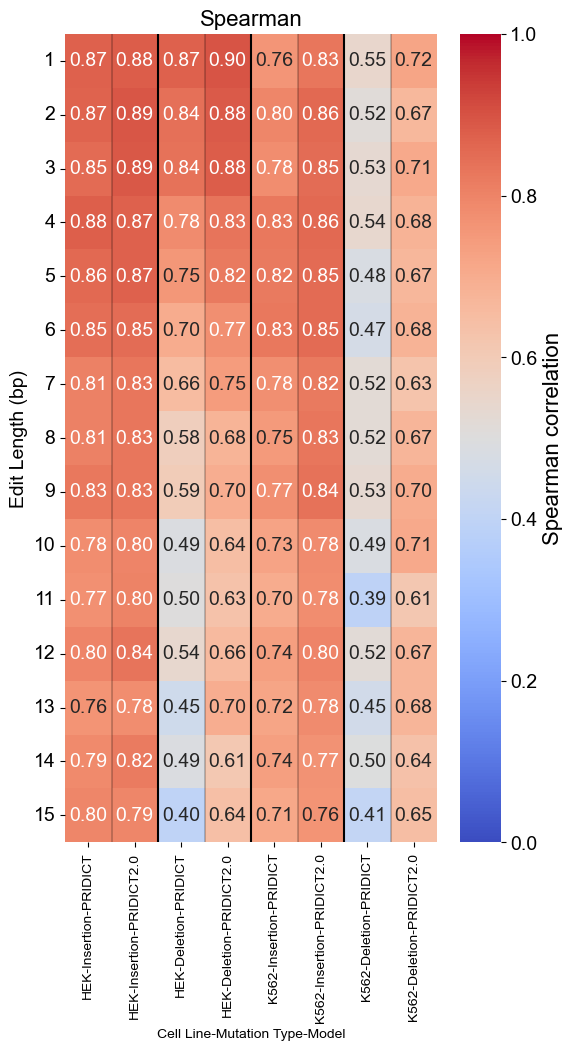

meta NOT subset; don't know how to subset; dropped


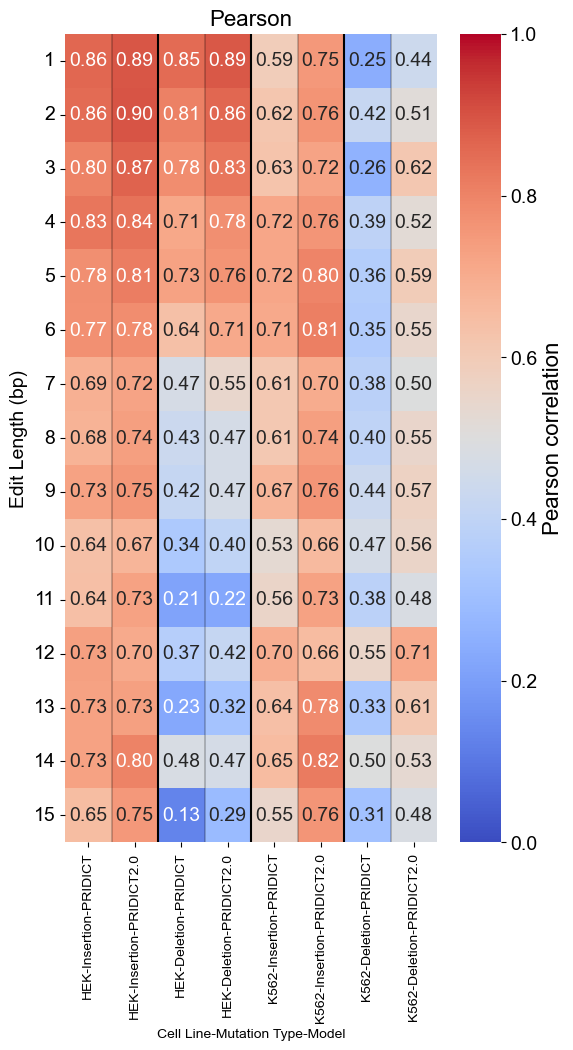

In [17]:
# Initialize empty DataFrames
spearman_dict = {}
pearson_dict = {}

def plot_combined_heatmap(df, title, filename=None):
    # Transpose the DataFrame and sort the index in descending order
    df_t = df.T.sort_index(ascending=True)
    
    plt.figure(figsize=(6, 10.5))
    ax = sn.heatmap(df_t, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14}, vmin=0, vmax=1)

    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel(title + ' correlation', size=16)
    cbar.ax.tick_params(labelsize=14)

    

    # Manually add vertical lines
    for x in range(1, df_t.shape[1]):
        if x % 2 == 1:
            ax.vlines(x, *ax.get_ylim(), color='black', linewidth=0.3)
        else:
            ax.vlines(x, *ax.get_ylim(), color='black', linewidth=1.5)

    # Set the size of y-axis labels and title
    ax.set_ylabel('Edit Length (bp)', fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
    
    plt.title(title, fontsize=16)
    
    if filename:
        path = '../08_Paper/01_Figures/Extended_2_PRIDICT2/'
        plt.savefig(f"{path}{filename}", format='pdf')
        
    plt.show()

cell_lines = ['HEK', 'K562']
mutation_length_types = range(1, 16)  # Assume you have lengths 1 to 15
mutation_types = ['Insertion', 'Deletion']

for cell_line in cell_lines:
    for mutation_type in mutation_types:
        for model in ['PRIDICT', 'PRIDICT2.0']:
            for mutation_length in mutation_length_types:
                model_key = 'PRIDICT1' if model == 'PRIDICT' else '90k_390k_ensemble'
                spearman_val = spearmandict_length[model_key][cell_line][mutation_type][mutation_length]
                pearson_val = pearsondict_length[model_key][cell_line][mutation_type][mutation_length]

                index_tuple = (cell_line, mutation_type, model)
                if index_tuple not in spearman_dict:
                    spearman_dict[index_tuple] = {}
                    pearson_dict[index_tuple] = {}
                
                spearman_dict[index_tuple][mutation_length] = spearman_val
                pearson_dict[index_tuple][mutation_length] = pearson_val

# Convert to DataFrames
spearman_df = pd.DataFrame.from_dict(spearman_dict, orient='index')
pearson_df = pd.DataFrame.from_dict(pearson_dict, orient='index')

# Name the hierarchical index levels and columns
spearman_df.index.names = ['Cell Line', 'Mutation Type', 'Model']
spearman_df.columns.name = 'Edit Length'

pearson_df.index.names = ['Cell Line', 'Mutation Type', 'Model']
pearson_df.columns.name = 'Edit Length'

# Plotting Heatmaps
plot_combined_heatmap(spearman_df, 'Spearman', 'Ins_Del_Length_spearman_correlation_heatmap.pdf')
plot_combined_heatmap(pearson_df, 'Pearson', 'Ins_Del_Length_pearson_correlation_heatmap.pdf')